In [24]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR  # 3번: CosineAnnealingLR 추가
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil  # 폴더 구조 생성에 필요

In [25]:
# GPU 또는 CPU 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [26]:
# 데이터 경로 설정
BASE_DIR = os.path.join(os.getcwd(), "resized")
IMG_DIR = BASE_DIR
CLASS_DIRS = {
    "normal": os.path.join(BASE_DIR, "normal"),
    "mild": os.path.join(BASE_DIR, "mild"),
    "moderate": os.path.join(BASE_DIR, "moderate"),
    "severe": os.path.join(BASE_DIR, "severe"),
    "very_severe": os.path.join(BASE_DIR, "very_severe")
}
ACNE_NAME_MAP = {0: "mild", 1: "moderate", 2: "severe", 3: "very_severe"}
CLASS_ID_MAP = {"normal": 0, "mild": 1, "moderate": 2, "severe": 3, "very_severe": 4}
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
NUM_CLASSES = 5
EPOCHS = 5
BATCH_SIZE = 16  # CPU면 16으로 줄이기

In [27]:
# 이미지 파일 확인 함수
def is_image(p):
    return os.path.isfile(p) and p.lower().endswith(IMG_EXTS)

def file_exists(p):
    try:
        return os.path.exists(p)
    except:
        return False

In [28]:
# 데이터 전처리: CSV 생성
rows = []
for label_name, class_dir in CLASS_DIRS.items():
    if os.path.isdir(class_dir):
        class_files = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True) if is_image(p)]
        print(f"[DEBUG] {label_name} files found: {len(class_files)}")
        for fp in class_files:
            rows.append([fp, label_name, CLASS_ID_MAP[label_name], "dataset_A", "unassigned", None, None])
    else:
        print(f"[WARN] {label_name} directory not found: {class_dir}")

txt_files = sorted(glob(os.path.join(BASE_DIR, "NNEW_*.txt")))
for txt in txt_files:
    given_split = os.path.basename(txt)
    with open(txt, "r", encoding="utf-8-sig") as fh:
        for line in fh:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            filename = parts[0]
            try:
                sev_id = int(parts[1])
            except:
                continue
            label_name = ACNE_NAME_MAP.get(sev_id, "unknown")
            if label_name == "unknown":
                continue
            label_id = CLASS_ID_MAP[label_name]
            fp = os.path.join(IMG_DIR, filename)
            group_id = parts[2] if len(parts) >= 3 else None
            rows.append([fp, label_name, label_id, "dataset_B", given_split, sev_id, group_id])

df = pd.DataFrame(rows, columns=[
    "filepath", "label_name", "label_id", "source", "given_split", "orig_severity_id", "group_id"
])
df = df[df["filepath"].apply(file_exists)].drop_duplicates(subset="filepath").reset_index(drop=True)
print("Label distribution:\n", df["label_name"].value_counts())
print("Sample 5 rows:\n", df.head())
out_csv = os.path.join(BASE_DIR, "labels_total.csv")
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"Saved: {out_csv}")

[DEBUG] normal files found: 936
[DEBUG] mild files found: 359
[DEBUG] moderate files found: 95
[DEBUG] severe files found: 128
[DEBUG] very_severe files found: 90
Label distribution:
 label_name
normal         936
mild           359
severe         128
moderate        95
very_severe     90
Name: count, dtype: int64
Sample 5 rows:
                                             filepath label_name  label_id  \
0  c:\Users\Admin\work space\data\resized\normal\...     normal         0   
1  c:\Users\Admin\work space\data\resized\normal\...     normal         0   
2  c:\Users\Admin\work space\data\resized\normal\...     normal         0   
3  c:\Users\Admin\work space\data\resized\normal\...     normal         0   
4  c:\Users\Admin\work space\data\resized\normal\...     normal         0   

      source given_split orig_severity_id group_id  
0  dataset_A  unassigned             None     None  
1  dataset_A  unassigned             None     None  
2  dataset_A  unassigned             None     

In [29]:
# 데이터셋 분할: Train/Val/Test
df = pd.read_csv(out_csv)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label_name"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df["label_name"], random_state=42)
train_df.to_csv(os.path.join(BASE_DIR, "split_train.csv"), index=False)
val_df.to_csv(os.path.join(BASE_DIR, "split_val.csv"), index=False)
test_df.to_csv(os.path.join(BASE_DIR, "split_test.csv"), index=False)
print("Train:", train_df["label_name"].value_counts())
print("Val:", val_df["label_name"].value_counts())
print("Test:", test_df["label_name"].value_counts())

Train: label_name
normal         654
mild           251
severe          90
moderate        67
very_severe     62
Name: count, dtype: int64
Val: label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64
Test: label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64


In [30]:
# 학습 데이터 밸런싱
targets = {"normal": 1000, "mild": 800, "moderate": 800, "severe": 500, "very_severe": 500}
def make_balanced(df, targets, label_col="label_name", seed=42):
    rng = np.random.default_rng(seed)
    outs = []
    for lab, n in targets.items():
        sub = df[df[label_col] == lab]
        if len(sub) == 0:
            continue
        if len(sub) >= n:
            outs.append(sub.sample(n=n, random_state=seed))
        else:
            idx = rng.choice(sub.index.to_numpy(), size=n, replace=True)
            outs.append(df.loc[idx])
    return pd.concat(outs, ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)

train_bal = make_balanced(train_df, targets)
train_bal.to_csv(os.path.join(BASE_DIR, "split_train.balanced.csv"), index=False)
val_df.to_csv(os.path.join(BASE_DIR, "split_val.balanced.csv"), index=False)
test_df.to_csv(os.path.join(BASE_DIR, "split_test.balanced.csv"), index=False)
print(train_bal["label_name"].value_counts().sort_index())

label_name
mild            800
moderate        800
normal         1000
severe          500
very_severe     500
Name: count, dtype: int64


In [31]:
# 폴더 구조 생성 (CSV 기반)
def organize_folders(csv_path, dest_folder):
    df = pd.read_csv(csv_path)
    os.makedirs(dest_folder, exist_ok=True)
    for _, row in df.iterrows():
        label = row['label_name']
        src_path = row['filepath']
        dest_label_dir = os.path.join(dest_folder, label)
        os.makedirs(dest_label_dir, exist_ok=True)
        dest_path = os.path.join(dest_label_dir, os.path.basename(src_path))
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

organize_folders(os.path.join(BASE_DIR, "split_train.balanced.csv"), os.path.join(BASE_DIR, "train"))
organize_folders(os.path.join(BASE_DIR, "split_val.balanced.csv"), os.path.join(BASE_DIR, "val"))
organize_folders(os.path.join(BASE_DIR, "split_test.balanced.csv"), os.path.join(BASE_DIR, "test"))
print("Folder structure created!")

Folder structure created!


In [32]:
# 데이터 로드 및 증강
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, "test"), transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# 클래스 가중치 계산
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)], dtype=torch.float).to(DEVICE)
print(f"Class weights: {class_weights}")

Class weights: tensor([1.1515, 0.8106, 0.4218, 3.2297, 4.5933])


In [34]:
import torch
import torchvision.models as models
import torch.nn as nn

# ResNet18 모델 로드
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # 또는 weights='IMAGENET1K_V1'
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # 출력 레이어 수정
model = model.to(DEVICE)  # GPU/CPU로 모델 이동

In [35]:
# 4번: 전이 학습 세부 조정 (사전 학습 레이어 고정, 마지막 레이어만 학습)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True  # 마지막 classifier 레이어만 학습 가능

In [36]:
# 학습 설정 - 3번: 학습률 0.001로 증가, CosineAnnealingLR 사용
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # 학습 가능한 파라미터만 최적화
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # 10 에폭마다 학습률 코사인 형태로 조정

In [38]:
# 학습 루프
best_val_loss = float('inf')
patience = 5
counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    scheduler.step()  # CosineAnnealingLR은 매 에폭마다 호출

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), os.path.join(BASE_DIR, "best_acne_model.pth"))
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1: 100%|██████████| 130/130 [02:41<00:00,  1.24s/it]


Epoch 1/5 - Train Loss: 1.2988, Train Acc: 56.07% - Val Loss: 0.7268, Val Acc: 79.96%


Epoch 2: 100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch 2/5 - Train Loss: 1.0338, Train Acc: 67.78% - Val Loss: 0.4944, Val Acc: 83.76%


Epoch 3: 100%|██████████| 130/130 [03:33<00:00,  1.64s/it]


Epoch 3/5 - Train Loss: 0.9269, Train Acc: 69.91% - Val Loss: 0.4697, Val Acc: 83.33%


Epoch 4: 100%|██████████| 130/130 [04:30<00:00,  2.08s/it]


Epoch 4/5 - Train Loss: 0.9046, Train Acc: 70.00% - Val Loss: 0.4578, Val Acc: 84.49%


Epoch 5: 100%|██████████| 130/130 [02:24<00:00,  1.11s/it]


Epoch 5/5 - Train Loss: 0.8472, Train Acc: 73.05% - Val Loss: 0.4421, Val Acc: 85.13%


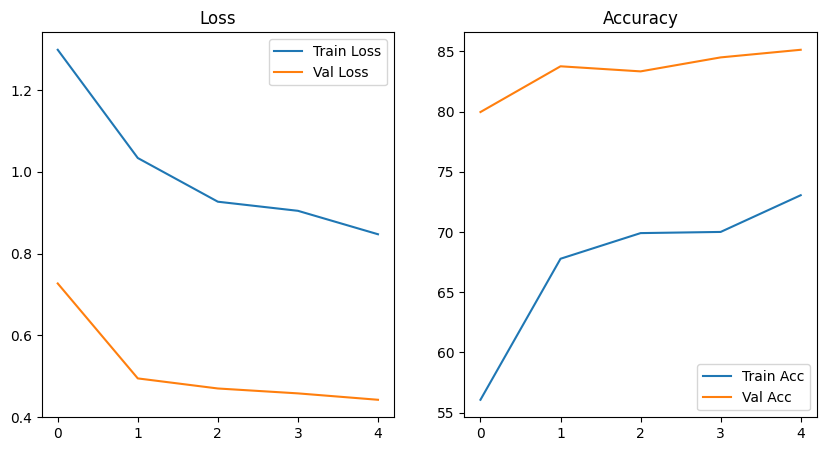

In [39]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()